In [3]:
import sys
import os
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)

In [7]:
from src.utils.root import get_temp_data_abs_path
log_file = get_temp_data_abs_path() + "/final_run/log.txt"

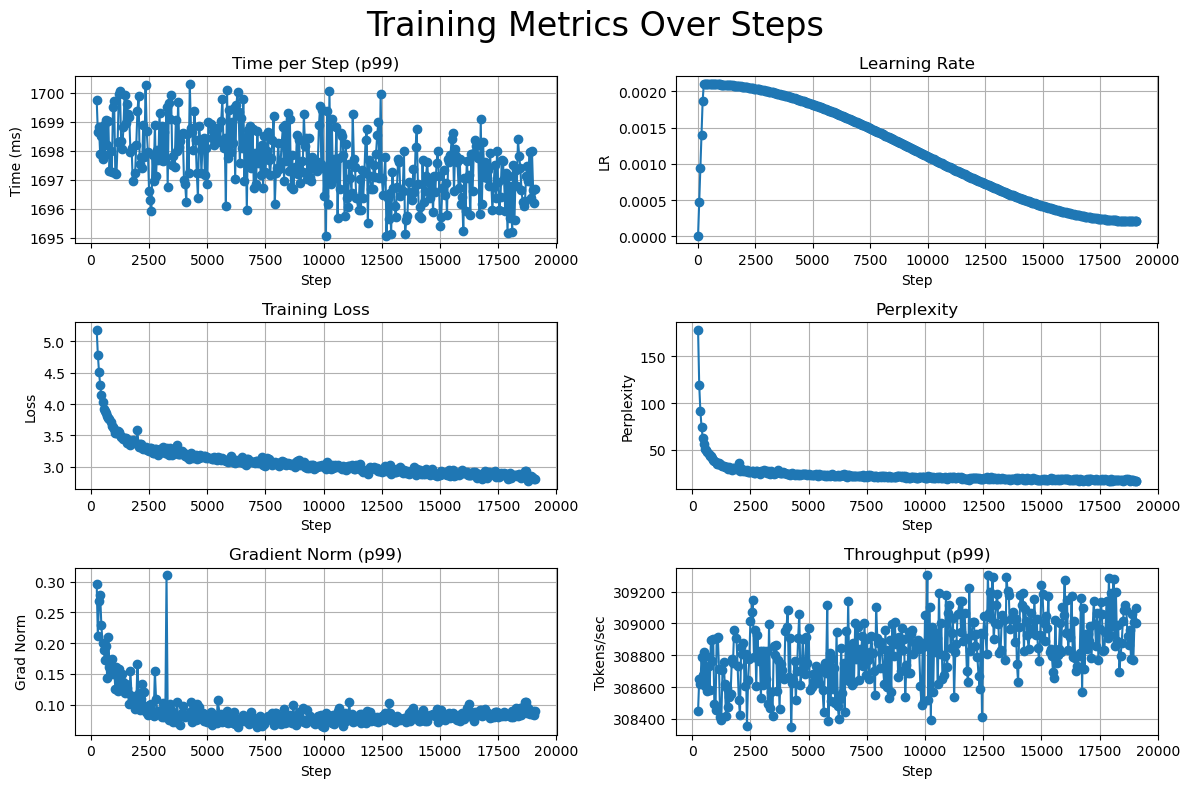

In [25]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# One-line training metrics
# 2024-12-07 04:42:46,563 - __main__ - INFO - Step 17950: Time: 1697.14 ms. LR: 2.2651e-04. Avg. loss: 2.8289. Perplexity: 16.9273. Grad Norm: 0.0833. Throughput: 308,924.65 tokens/sec
train_pattern = re.compile(
    r"Step\s+(?P<step>\d+):\s+Time:\s+(?P<time>[\d.]+)\s+ms.\s+LR:\s+(?P<lr>[\deE.-]+).\s+Avg.\s+loss:\s+(?P<avg_loss>[\d.]+).\s+Perplexity:\s+(?P<perp>[\d.]+).\s+Grad\s+Norm:\s+(?P<grad_norm>[\d.]+).\s+Throughput:\s+(?P<throughput>[\d.,]+)\s+tokens/sec"
)

steps = []
times = []
lrs = []
avg_losses = []
perplexities = []
grad_norms = []
throughputs = []

with open(log_file, 'r') as f:
    for line in f:
        match = train_pattern.search(line)
        if match:
            steps.append(int(match.group('step')))
            times.append(float(match.group('time')))
            lrs.append(float(match.group('lr')))
            avg_losses.append(float(match.group('avg_loss')))
            perplexities.append(float(match.group('perp')))
            grad_norms.append(float(match.group('grad_norm')))
            throughput_str = match.group('throughput').replace(',', '')
            throughputs.append(float(throughput_str))

df = pd.DataFrame({
    'step': steps,
    'time_ms': times,
    'lr': lrs,
    'avg_loss': avg_losses,
    'perplexity': perplexities,
    'grad_norm': grad_norms,
    'throughput': throughputs
})

# Keep original DataFrame for LR graph
orig_df = df
# Exclude first entry because it's too noisy
df = df.iloc[1:]

# Clean outliers for time, throughput, and grad-norm
time_threshold = df['time_ms'].quantile(0.99) 
throughput_threshold = df['throughput'].quantile(0.99)
grad_norm_threshold = df['grad_norm'].quantile(0.99)

df = df[
    (df['time_ms'] <= time_threshold) &
    (df['throughput'] <= throughput_threshold) &
    (df['grad_norm'] <= grad_norm_threshold)
]

plt.figure(figsize=(12,8))

plt.subplot(3,2,1)
plt.plot(df['step'], df['time_ms'], marker='o', label='Time (ms)')
plt.xlabel('Step')
plt.ylabel('Time (ms)')
plt.title('Time per Step (p99)')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(orig_df['step'], orig_df['lr'], marker='o', label='Learning Rate')
plt.xlabel('Step')
plt.ylabel('LR')
plt.title('Learning Rate')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(df['step'], df['avg_loss'], marker='o', label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(df['step'], df['perplexity'], marker='o', label='Perplexity')
plt.xlabel('Step')
plt.ylabel('Perplexity')
plt.title('Perplexity')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(df['step'], df['grad_norm'], marker='o', label='Grad Norm')
plt.xlabel('Step')
plt.ylabel('Grad Norm')
plt.title('Gradient Norm (p99)')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(df['step'], df['throughput'], marker='o', label='Throughput')
plt.xlabel('Step')
plt.ylabel('Tokens/sec')
plt.title('Throughput (p99)')
plt.grid(True)

plt.suptitle('Training Metrics Over Steps', fontsize=24, y=0.98)
plt.tight_layout()
plt.show()


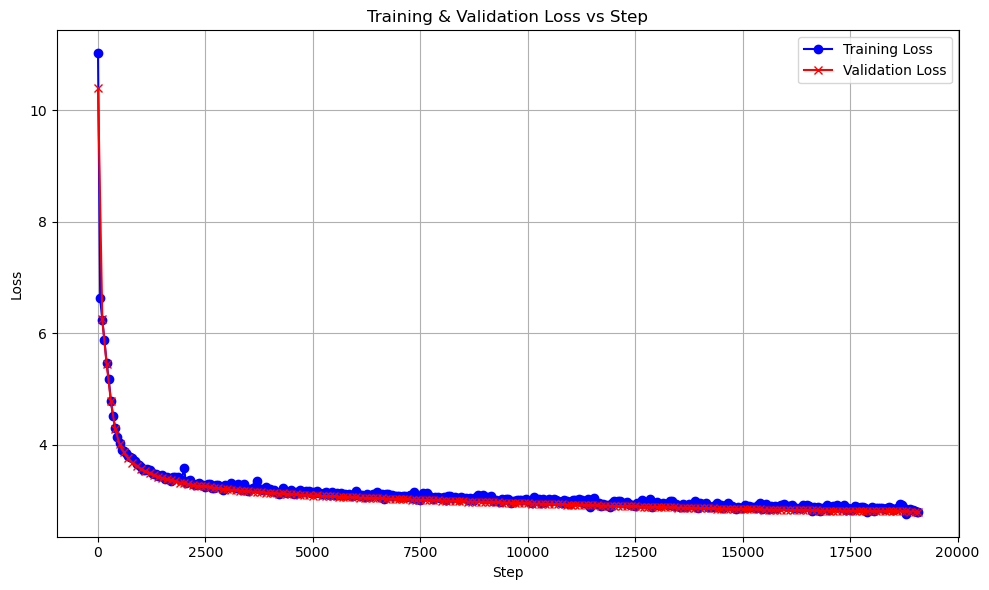

In [26]:
# Plot training and val loss
# 2024-12-07 04:44:09,845 - src.model_assessment.validation - INFO - Step (18000). Val Loss: 2.8128
val_pattern = re.compile(r"Step\s*\((?P<step>\d+)\)\.\s*Val\s+Loss:\s+(?P<val_loss>[\d.]+)")
# 2024-12-07 04:42:46,563 - __main__ - INFO - Step 17950: Time: 1697.14 ms. LR: 2.2651e-04. Avg. loss: 2.8289. Perplexity: 16.9273. Grad Norm: 0.0833. Throughput: 308,924.65 tokens/sec
train_loss_pattern = re.compile(r"Step\s+(?P<step>\d+):.*Avg.\s+loss:\s+(?P<avg_loss>[\d.]+)\.")

val_steps = []
val_losses = []
train_steps_2 = []
train_losses_2 = []

with open(log_file, 'r') as f:
    for line in f:
        val_match = val_pattern.search(line)
        if val_match:
            step = int(val_match.group('step'))
            val_loss = float(val_match.group('val_loss'))
            val_steps.append(step)
            val_losses.append(val_loss)

        train_match_2 = train_loss_pattern.search(line)
        if train_match_2:
            step = int(train_match_2.group('step'))
            avg_loss = float(train_match_2.group('avg_loss'))
            train_steps_2.append(step)
            train_losses_2.append(avg_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_steps_2, train_losses_2, label='Training Loss', marker='o', color='blue')
plt.plot(val_steps, val_losses, label='Validation Loss', marker='x', color='red')
plt.title('Training & Validation Loss vs Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

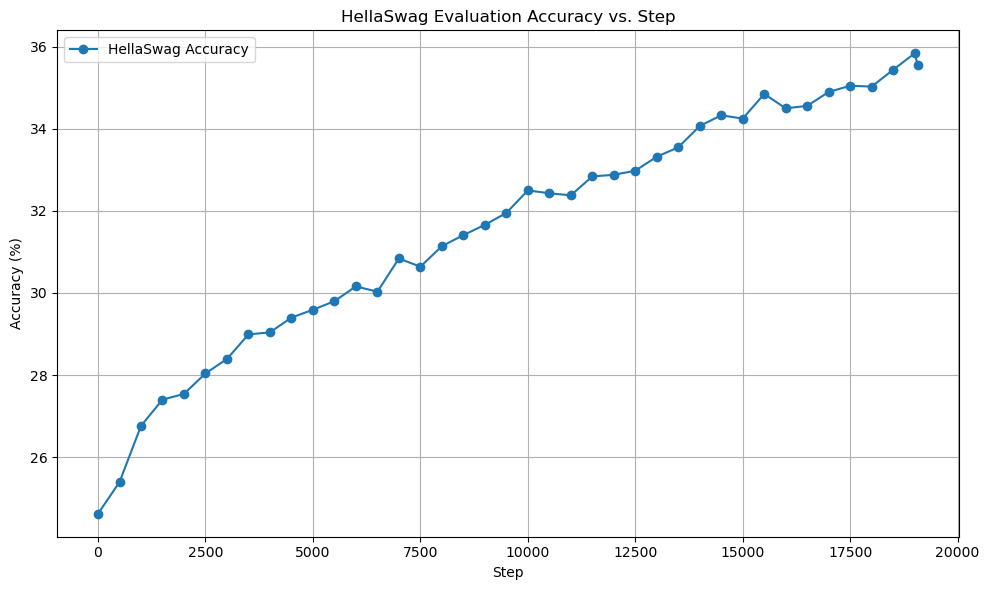

In [28]:
# Plot HellaSwag eval accuracy
hellaswag_pattern = re.compile(
    r"Step\s*\((?P<step>\d+)\)\.\s*HellaSwag\s+Evaluation\s+Accuracy:\s*\d+/\d+\s*=\s*(?P<accuracy>[\d.]+)%"
)

hs_steps = []
hs_accuracies = []

with open(log_file, 'r') as f:
    for line in f:
        match = hellaswag_pattern.search(line)
        if match:
            step = int(match.group('step'))
            accuracy = float(match.group('accuracy'))
            hs_steps.append(step)
            hs_accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(hs_steps, hs_accuracies, marker='o', label='HellaSwag Accuracy')
plt.title('HellaSwag Evaluation Accuracy vs. Step')
plt.xlabel('Step')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()